Этот код из столбца с текстом предложений создаёт таблицу

id | sent_index | token | tag
- | - | - | -
1 | 1| слово1 |B-TERM
2 | 1| слово2 |O
3 | 1| слово3 |B-DEF
4 | 1| слово4 |I-DEF

В которой передложения с определением размечаются тегами B-TERM, I-TERM, B-DEF, I-DEF O.

Если определение не найдено, у всех слов тег O. А has_def для предложения = 0.

Можно использовать этот код для первоначальной BIO разметки, которую после ручной выверки можно давать нейросети. 

In [1]:
! pip install -U 'scikit-learn<0.24'

In [2]:
import pandas as pd
import re
import sklearn_crfsuite
from sklearn_crfsuite import metrics
from sklearn.metrics import classification_report

In [3]:
! pip install natasha

In [4]:
! pip install sklearn-crfsuite

In [5]:
from natasha import (
    Segmenter,
    MorphVocab,
    
    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,
    
    PER,
    NamesExtractor,

    Doc
)


segmenter = Segmenter()

In [6]:
punctuation = '''!#$%&*+, -./:;=?@\^_`|~'''

def get_TD_witheto(sent):
 
    pattern = '(?P<term>(.+?)\s*?)(\s\(.*?\))?\s—\sэто\s(?P<def>.+)'
    result = re.search(pattern, sent)

    if result:
        return [result.group('term'), result.group('def').strip(punctuation)]
    return None

def get_TD_withdash(sent):
 
    pattern = '(?P<term>(.+?)\s*?)(\s\(.*?\))?\s—\s(это\s)?(?P<def>.+)'
    result = re.search(pattern, sent)

    if result:
        return [result.group('term'), result.group('def').strip(punctuation)]
    return None

def get_TD_withie1(sent):
 
    pattern = '(?P<term>(\S+?))\s\(то\sесть\s(?P<def>(.+?)\s*?)\)'
    result = re.search(pattern, sent)

    if result:
        return [result.group('term'), result.group('def').strip(punctuation)]
    return None

def get_TD_withie2(sent):
 
    pattern = '(?P<term>(\S+?)),\sто\sесть\s(?P<def>.+)'
    result = re.search(pattern, sent)

    if result:
        return [result.group('term'), result.group('def').strip(punctuation)]
    return None

def get_TD_withbrakets(sent):
 
    pattern = '(?P<term>(\S+?))\s\((?P<def>(.+?)\s*?)\)'
    result = re.search(pattern, sent)

    if result:
        return [result.group('term'), result.group('def').strip(punctuation)]
    return None

def get_TD_withnames1(sent):
 
    pattern = '(?P<term>(\S+?))(,\sто\s(он|она|оно|они)\s)?\s(называется|называют|является)\s(также\s)?(?P<def>.+)'
    result = re.search(pattern, sent)

    if result:
        return [result.group('term'), result.group('def').strip(punctuation)]

def get_TD_withnames2(sent):
 
    pattern = '(?P<def>.+?)\sназываются\s(?P<term>(\S+?))'
    result = re.search(pattern, sent)

    if result:
        return [result.group('term'), result.group('def').strip(punctuation)]

def get_TD_withmeans(sent):
 
    pattern = '\sопределяет\s(?P<term>(\S+?))\sкак\s(?P<def>.+)'
    result = re.search(pattern, sent)

    if result:
        return [result.group('term'), result.group('def').strip(punctuation)]
    return None

def get_TD_withest(sent):
 
    pattern = '(?P<term>(\S+?))(\s.+)\sесть\s(?P<def>.+)'
    result = re.search(pattern, sent)

    if result:
        return [result.group('term'), result.group('def').strip(punctuation)]
    return None

def get_TD_withpodraz(sent):
 
    pattern = '(П|п)од\s(?P<term>(\S+?))\s(подразумевается|(следует\sпонимать))(?P<def>.+)'
    result = re.search(pattern, sent)

    if result:
        return [result.group('term'), result.group('def').strip(punctuation)]
    return None

In [7]:
has_def = []

# открываем дф
df = pd.read_csv('sents_Wiki_tagged.csv', sep=';', dtype={'sent_index': str, 'sent_text': str, 'def': int})

# токенизируем, записываем в дф, изначальный тег для всех токенов - О
def tokens_to_df(df):
    tokens_data = []
    for index, row in df.iterrows():
        # print(row['sent_text'])
        term_def = get_TD_witheto(row['sent_text'])
        if term_def == None:
            term_def = get_TD_withie1(row['sent_text'])
        if term_def == None:
            term_def = get_TD_withie2(row['sent_text'])
        if term_def == None:
            term_def = get_TD_withpodraz(row['sent_text'])
        if term_def == None:
            term_def = get_TD_withmeans(row['sent_text'])
        if term_def == None:
            term_def = get_TD_withnames1(row['sent_text'])
        if term_def == None:
            term_def = get_TD_withnames2(row['sent_text'])
        if term_def == None:
            term_def = get_TD_withest(row['sent_text'])
        if term_def == None:
            term_def = get_TD_withdash(row['sent_text'])
        #if term_def == None:
            #term_def = get_TD_withbrakets(row['sent_text'])
        if term_def == None:
            term_def = ['', '']
        # print(term_def)
        doc = Doc(row['sent_text'])
        sentences = doc.segment(segmenter)
        for tok in doc.tokens:
            if tok.text in term_def[0]:
                if term_def[0].startswith(tok.text):
                    tokens_data.append((row['sent_index'], tok.text, 'B-TERM'))
                else:
                    tokens_data.append((row['sent_index'], tok.text, 'I-TERM'))
            elif tok.text in term_def[1]:
                if term_def[1].startswith(tok.text):
                    tokens_data.append((row['sent_index'], tok.text, 'B-DEF'))
                else:
                    tokens_data.append((row['sent_index'], tok.text, 'I-DEF'))
            else:
                tokens_data.append((row['sent_index'], tok.text, 'O'))
        if term_def == ['', '']:
            has_def.append(0)
        else:
            has_def.append(1)
    df = pd.DataFrame(tokens_data, columns = ['sent_index', 'token', 'tag'])
    return df

# делаем новую дф
df_table2_rules_tokens = tokens_to_df(df)

# сохраняем в .csv
df_table2_rules_tokens.to_csv('table2_baseline1.csv', sep=';')

# Смотрим качество

### Качество классификации

In [8]:
 df['def_rules'] = has_def
 df

,Unnamed: 0,sent_index,sent_text,def,def_rules
0,0,0,"Лингви́стика (от лат. lingua «язык»), языкозна...",1,1
1,1,12,"Как дисциплина, имеющая ряд принципиальных чер...",1,1
2,2,13,"Лингвистами часто становятся люди, совмещающие...",1,0
3,3,15,Лингвистика в широком смысле слова (познание я...,1,0
4,4,17,"Она бывает: нормативной: указывающей, как «на...",0,0
...,...,...,...,...,...
921,921,24786,Каждая задача впоследствии оценивается определ...,0,0
922,922,24787,"Командное соревнование, за исключением первой ...",0,0
923,923,24788,Сданное решение оценивается жюри по определённ...,0,0
924,924,24789,"Официальный сайт со статистикой, условиями и р...",0,0


In [9]:
error_1_0 = 0  # не найдено существующее определение
error_0_1 = 0  # найдено лишнее
for index, row in df.iterrows():
    if row['def'] > row['def_rules']:
        error_1_0 +=1
    if row['def'] < row['def_rules']:
        error_0_1 +=1
error_1_0, error_0_1, len(df)

(25, 103, 926)

In [10]:
gold = df['def']
pred = df['def_rules']
report = classification_report(gold, pred, target_names=['no term-def', 'term-def'])
print(report)

              precision    recall  f1-score   support

 no term-def       0.93      0.76      0.84       432
    term-def       0.82      0.95      0.88       494

    accuracy                           0.86       926
   macro avg       0.87      0.86      0.86       926
weighted avg       0.87      0.86      0.86       926



### Качество BIO разметки

In [11]:
# открываем дф
df_tags = pd.read_csv('tokens_Wiki_tagged.csv', sep=';', dtype={'sent_index': str, 'token': str, 'tag': str})

In [12]:
df_tags['tag_rules']= list(df_table2_rules_tokens['tag'])

In [13]:
df_tags

,Unnamed: 0,sent_index,token,tag,tag_rules
0,0,0,Лингви́стика,B-TERM,B-TERM
1,1,0,(,O,I-TERM
2,2,0,от,O,I-TERM
3,3,0,лат,O,I-TERM
4,4,0,.,O,I-TERM
...,...,...,...,...,...
26243,26322,24790,Первой,O,O
26244,26323,24790,международной,O,O
26245,26324,24790,лингвистической,O,O
26246,26325,24790,олимпиады,O,O


[[  422     1    27    17    62]
 [    1   411    18    51   110]
 [   53    43  7583   716   612]
 [    2     9    27   388    64]
 [  145   145  2244  1716 11381]]


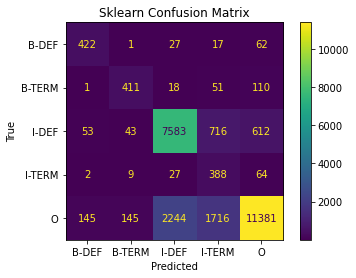

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
actual_data = df_tags['tag']

predicted_data = df_tags['tag_rules']
    
## Create the Confusion Matrix out of the Actual and Predicted Data.
cm = confusion_matrix(actual_data, predicted_data)

## Print the Confusion Matrix.
print(cm)

## Create the Confusion Matrix Display Object(cmd_obj). Note the 
## alphabetical sorting order of the labels.
cmd_obj = ConfusionMatrixDisplay(cm, display_labels=['B-DEF', 'B-TERM', 'I-DEF', 'I-TERM', 'O'])

## The plot() function has to be called for the sklearn visualization
## code to do its work and the Axes object to be created.
cmd_obj.plot()

## Use the Axes attribute 'ax_' to get to the underlying Axes object.
## The Axes object controls the labels for the X and the Y axes. It
## also controls the title.
cmd_obj.ax_.set(
                title='Sklearn Confusion Matrix', 
                xlabel='Predicted', 
                ylabel='True')

## Finally, call the matplotlib show() function to display the visualization
## of the Confusion Matrix.
plt.show()

In [36]:
labels = ['B-DEF', 'B-TERM', 'I-DEF', 'I-TERM', 'O']
y_test = [list(df_tags['tag'])]
y_pred = [list(df_tags['tag_rules'])]

metrics.flat_f1_score(y_test, y_pred, average='weighted', labels=labels)

0.796286684551161

In [37]:
labels = ['B-DEF', 'B-TERM', 'I-DEF', 'I-TERM', 'O']
print(metrics.flat_classification_report(y_test, y_pred, labels=labels, digits=3))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['B-DEF', 'B-TERM', 'I-DEF', 'I-TERM', 'O'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


              precision    recall  f1-score   support

       B-DEF      0.677     0.798     0.733       529
      B-TERM      0.675     0.695     0.685       591
       I-DEF      0.766     0.842     0.802      9007
      I-TERM      0.134     0.792     0.230       490
           O      0.931     0.728     0.817     15631

    accuracy                          0.769     26248
   macro avg      0.637     0.771     0.653     26248
weighted avg      0.848     0.769     0.796     26248

